In [231]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sunode
import pymc as pm
import arviz as az

In [232]:
data = pd.read_csv('CovidData.csv')

In [233]:
data.head()

,Dates,Total Cases,Daily New Cases,Active Cases,Total Deaths,Daily Deaths,New Recoveries
0,"Feb 15, 2020",3,0,0,0,0,0
1,"Feb 16, 2020",3,0,0,0,0,0
2,"Feb 17, 2020",3,0,0,0,0,0
3,"Feb 18, 2020",3,0,0,0,0,0
4,"Feb 19, 2020",3,0,0,0,0,0


In [234]:
N = 1366417754 #Population at 2019

In [235]:
I = data.loc[:, "Active Cases"]
R = data.loc[:, "New Recoveries"].cumsum()
S = N - I - R
X = data.loc[:, "Dates"]

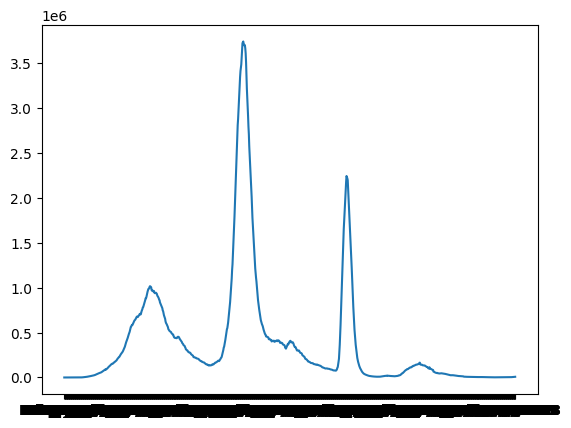

In [6]:
plt.plot(X, I)
plt.show()

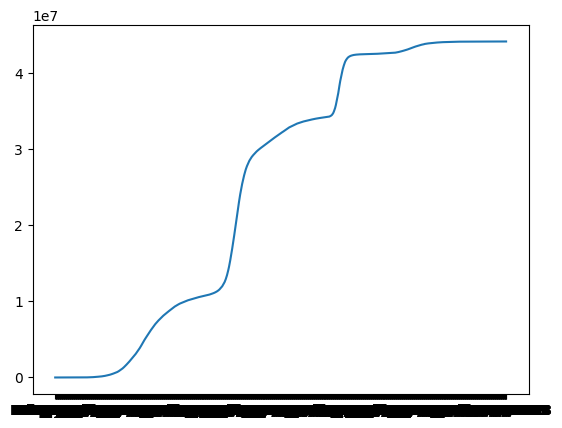

In [7]:
plt.plot(X, R)
plt.show()

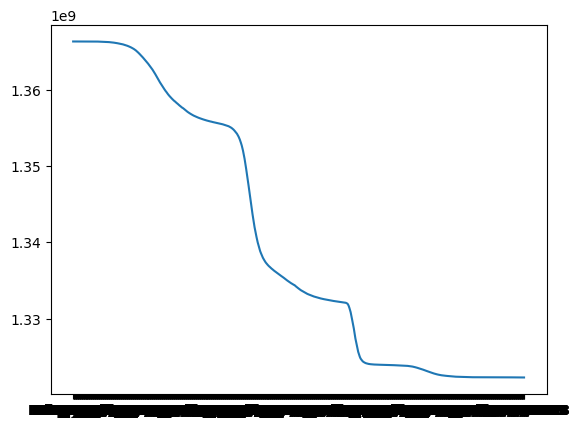

In [8]:
plt.plot(X, S)
plt.show()

In [236]:
import numpy as np
import sunode
import sunode.wrappers.as_pytensor
import pymc as pm
import pytensor.tensor as pt

from pytensor import function
from pytensor.printing import Print
from scipy.integrate import odeint

In [269]:
from sklearn.preprocessing import normalize, StandardScaler
#S_norm = normalize(S[:, np.newaxis] / N, axis = 0)
#I_norm = normalize(I[:, np.newaxis] / N, axis = 0)
#R_norm = normalize(R[:, np.newaxis] / N, axis = 0)
mean = np.mean(I)
std = np.std(I)
I_norm = (I) / std
S_norm = (S) / std
R_norm = (R) / std

In [270]:
S_new = S_norm[800:]
R_new = R_norm[800:]
I_new = I_norm[800:]
S_start = S_norm[799]
I_start = I_norm[799]
R_start = R_norm[799]
times = np.linspace(0, len(S_new), len(S_new))

In [271]:
def sir_sunode(t, y, p):
    return {
            'S': -p.beta * y.S * y.I / p.N,
            'I': p.beta * y.S * y.I / p.N - p.gamma * y.I,
            #'R': p.gamma * y.I
    }

In [272]:
import pytensor.tensor as pt
from pytensor.compile.ops import as_op
import sunode
import sunode.wrappers.as_pytensor
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-2:], t=times, args=(theta,))

In [302]:
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 2, shape = 1)
    beta = pm.Lognormal('lambda', 1.5, 1.5)
    gamma = pm.Lognormal('mu', 1.5, 1.5)

    #gamma_print = Print("gamma")(gamma)

    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
            'S': (S_start, ()),
            'I': (I_start, ()),
            'R': (R_start, ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to PyTensor variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'N': (N, ()),
        },
	# A functions that computes the right-hand-side of the ode using
	# sympy variables.
        rhs=sir_sunode,
	# The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )
    
    pm.Normal('I', mu = y_hat['I'], sigma = sigma, observed = I_new)

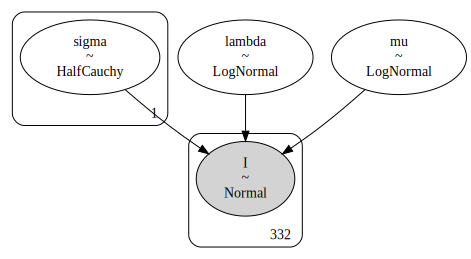

In [303]:
pm.model_to_graphviz(model=model)

In [304]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

In [305]:
with model:
    trace = pm.sample(draws = 1000, tune=0, chains=4, progressbar=True, random_seed = 0)

az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, lambda, mu]



[CVODES ERROR]  CVode
  At t = 331.197, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 330.181, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 329.168, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 328.161, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 327.145, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 326.127, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],1.344,0.489,0.860,1.827,0.303,0.244,3.0,3.0,NaN
lambda,21.670,15.775,6.048,37.293,9.783,7.888,3.0,3.0,NaN
mu,9.589,3.512,6.110,13.067,2.178,1.756,3.0,3.0,NaN


array([<Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'lambda'}>, <Axes: title={'center': 'mu'}>],
      dtype=object)

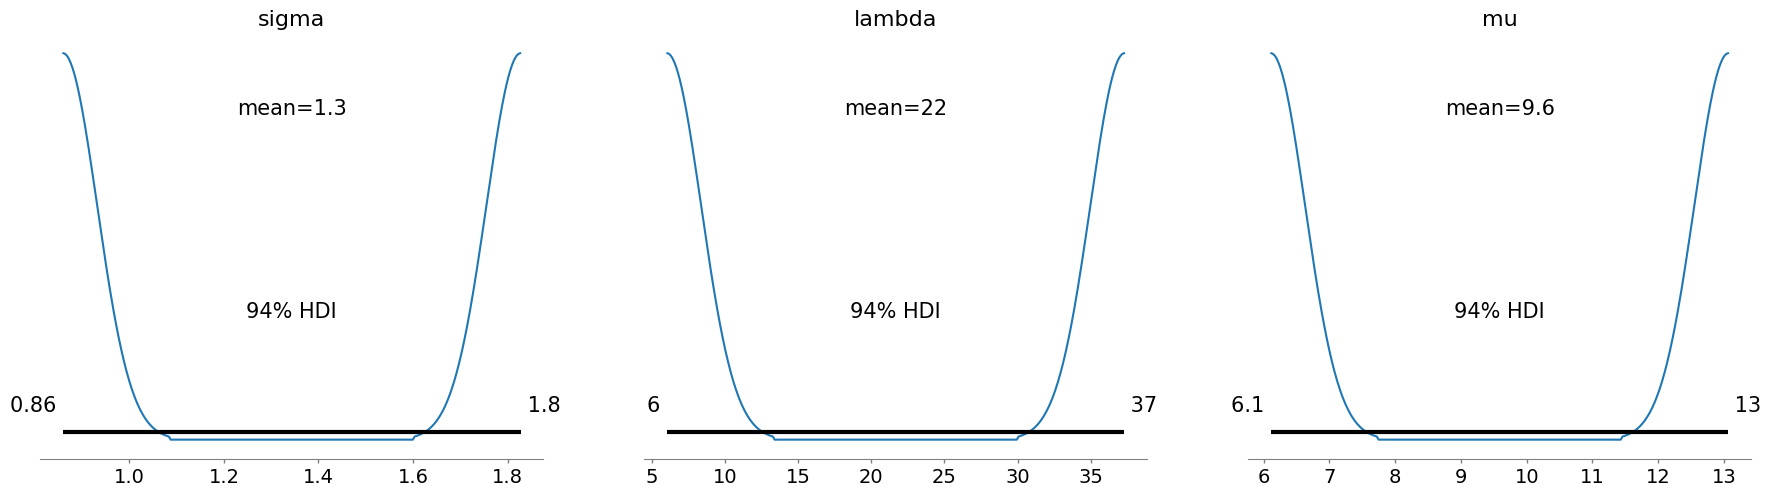

In [289]:
az.plot_posterior(trace, round_to=2)

/anaconda/envs/sunode-env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/anaconda/envs/sunode-env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/anaconda/envs/sunode-env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

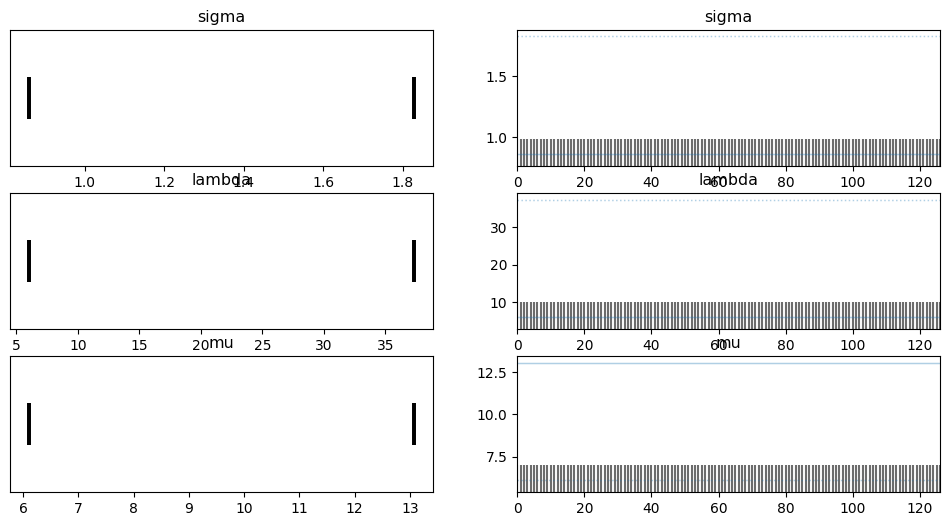

In [290]:
az.plot_trace(trace)

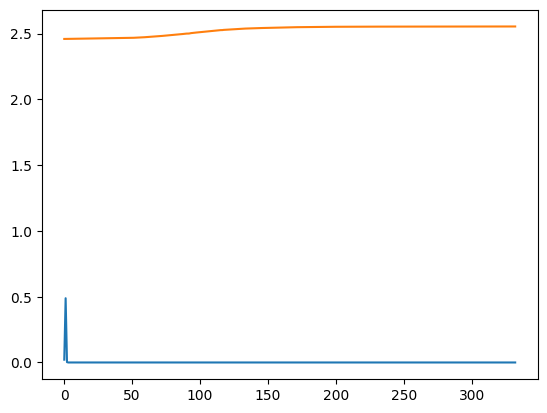

In [163]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
#N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
#I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
#S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.3, 5.3
# A grid of time points (in days)
#t = np.linspace(0, 150, 150)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S_start[0], I_start[0], R_start[0]
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, times, args=(N, beta, gamma))
I = ret[:, 1]

plt.plot(times, I, label = "Predict")
plt.plot(times, R_new[:, 0], label = "Data")

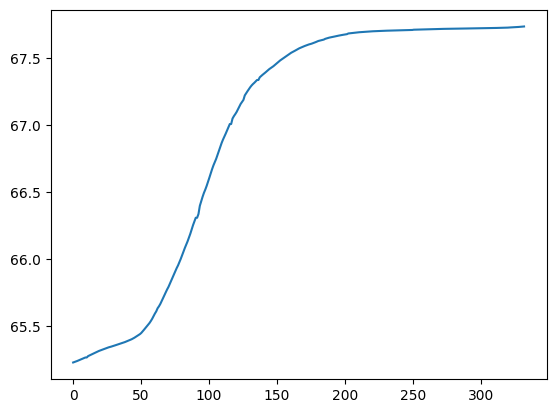

In [301]:
plt.plot(times, R_new, label = "Data")